
# Tutorial 1 — Resolución de un problema de difusión 2D con FVM

---

# Modelo matemático

Estamos resolviendo la ecuación de difusión estacionaria en 2D:

$$
\nabla \cdot (\Gamma \nabla \phi) = 0
$$

en el dominio cuadrado:

$$
\Omega = [0,1] \times [0,1]
$$

donde:

* $\phi(x,y)$ es la variable escalar desconocida.
* $\Gamma$ es el coeficiente de difusión (constante en este caso).

Como $\Gamma = 1$, la ecuación se reduce a la ecuación de Laplace:

$$
\nabla^2 \phi = 0
$$

---

## Condiciones de borde

Se imponen condiciones de Dirichlet en los cuatro lados:

| Borde | Condición  |
| ----- | ---------- |
| $x=0$ | $\phi = 0$ |
| $x=1$ | $\phi = 0$ |
| $y=0$ | $\phi = 0$ |
| $y=1$ | $\phi = 1$ |

Físicamente, esto representa:

* Tres paredes a temperatura cero.
* La pared superior a temperatura unitaria.

El problema es puramente difusivo y lineal.

---

# Implementación computacional

---

## Importación de librerías


In [3]:
from fidelio import *
import numpy as np

* `fidelio` contiene las clases:

  * `Tessellation`
  * `MeshFVM`
  * `FVMProblem`
* `numpy` se usa para operaciones numéricas.

## Definición del dominio

In [4]:
xl = 1
yl = 1

nx = ny = 8
x = np.linspace(0.0, xl, nx)
y = np.linspace(0.0, yl, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

1. Se definen 8 puntos en cada dirección.
2. Se genera una grilla estructurada 8×8.
3. Se crea un arreglo `points` con las coordenadas nodales.

El método FVM trabajará sobre una triangulación generada a partir de estos puntos.

## Triangulación

In [5]:
tess = Tessellation(points)

Se construye una triangulación no estructurada a partir de los nodos.

Esto permite trabajar con celdas triangulares en el método de volúmenes finitos.

## Construcción del objeto de malla FVM

In [6]:
mesh = MeshFVM(tess)
mesh.compute_fvm_geometry()

Aquí se calculan:

* Centros de celda
* Volúmenes
* Áreas de caras
* Normales
* Distancias centro-centro
* Conectividades

Estos datos son esenciales para construir los flujos difusivos.

## Visualización de la topología

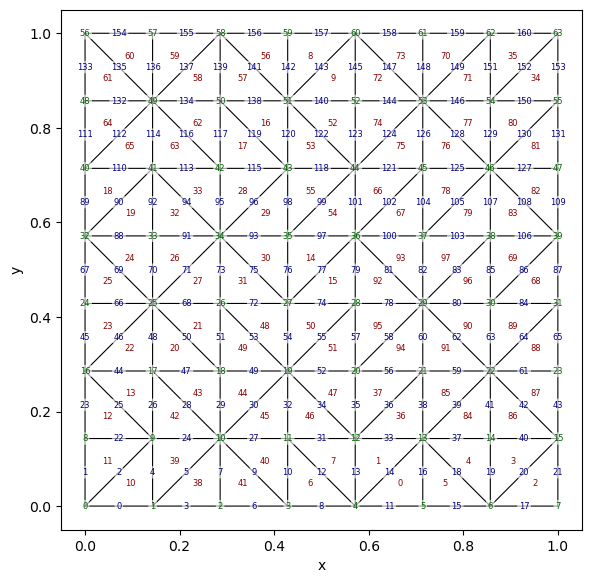

In [7]:
mesh.plot_topology(
    element_color = "darkred",
    face_color = "navy",
    node_color = "darkgreen",
    element_size = 6,
    face_size = 6,
    node_size = 6,
    figsize = (6, 6)
)

Se grafica:

* Elementos (triángulos)
* Caras
* Nodos

Esto permite verificar que la conectividad geométrica es correcta.

# Definición del problema FVM

In [8]:
p = FVMProblem(mesh)
p.initialize_phi(0.)
p._update_gradients()

* Se crea el problema asociado a la malla.
* Se inicializa (\phi = 0) en todas las celdas.
* Se calculan gradientes iniciales.

Aunque el problema es lineal, la estructura permite tratar problemas no lineales.

---

# Definición del coeficiente de difusión


In [9]:
def my_gamma(p):
    return np.full(p.Ne, 1.0)

Se define:

$$
\Gamma = 1
$$

para todas las celdas.

Luego:

In [10]:
p.gamma_function = my_gamma
p.initialize_gamma()

Esto:

* Evalúa Γ en celdas
* Interpola Γ a caras

## Cálculo de coeficientes difusivos

In [11]:
p.compute_diffusion_coefficients()

$$
F_{cf} = \frac{\Gamma_f S_f}{d_{Cf}}
$$

donde:

* $S_f$ es el área de la cara
* $d_{Cf}$ es la distancia centro-centro

Estos coeficientes formarán la matriz del sistema lineal.

---

# Identificación de caras de borde

In [12]:
tol = 1e-6
face_centers = np.array([f.center for f in p.mesh.faces])

Se obtienen los centros de todas las caras.

Luego se identifican por coordenada:

In [13]:
left_bound  = np.where(np.abs(face_centers[:, 0]) < tol)[0]
right_bound = np.where(np.abs(face_centers[:, 0] - xl) < tol)[0]
down_bound  = np.where(np.abs(face_centers[:, 1]) < tol)[0]
up_bound    = np.where(np.abs(face_centers[:, 1] - yl) < tol)[0]

## Creación de patches

In [14]:
bounds = {
    "left_bound"  : left_bound,
    "right_bound" : right_bound,
    "down_bound"  : down_bound,
    "up_bound"    : up_bound
}

p.create_boundary_patches(bounds)

Cada patch almacena:

* Caras
* Celdas adyacentes
* Áreas
* Distancias

Esto facilita aplicar condiciones de borde.

# Implementación de condiciones Dirichlet

Para una Dirichlet:

$$
\phi_b = \phi_{prescrita}
$$

se obtiene:

$$
S_P = \frac{\Gamma S_f}{d_{Cf}}
$$

$$
S_C = S_P \phi_b
$$

In [15]:
def my_boundary_sources(p):
    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)

    patch = p.left_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.right_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.down_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.up_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 1
    return Sc, Sp

Se asigna la función:

In [16]:
p.boundary_sources_function = my_boundary_sources
p.calculate_boundary_sources()

# Ensamblaje del sistema

In [17]:
p.assemble_system()

Se construye:

$$
A \phi = b
$$

donde:

* La matriz A proviene de flujos difusivos
* b incluye las contribuciones de borde

# Resolución

In [18]:
p.solve()

problem solved...


Se grafican contornos del campo escalar en celdas.

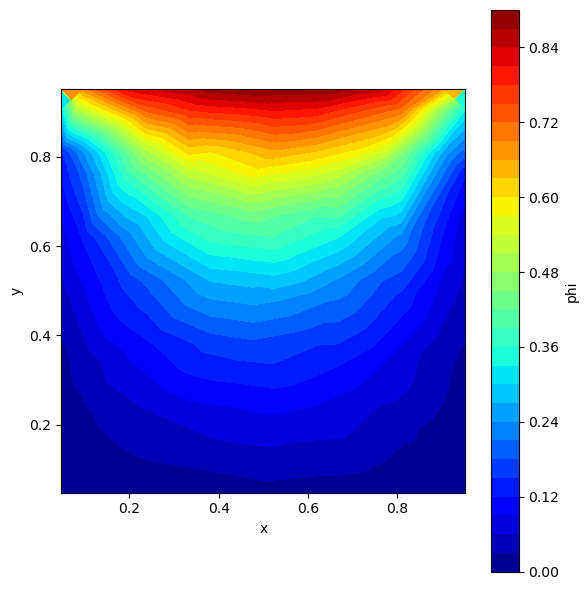

In [19]:
plot_phi_contours(
    p,
    field="cell",
    levels = 30,
    cmap="jet",
    include_internal_faces=False,
    include_boundary_faces=True,
    show_contour_lines=False,
    figsize=(6, 6)
)

## Validación

En esta sección se valida el esquema de Volúmenes Finitos comparando la solución numérica con la **solución analítica exacta** del problema de Laplace en una placa rectangular.

Se resuelve nuevamente la ecuación de Laplace:

$$
\nabla^2 \theta = 0
$$

en el dominio rectangular:

$$
0 \le x \le L, \quad 0 \le y \le W
$$

con condiciones de borde:

$$
\theta(0,y) = 0
$$

$$
\theta(L,y) = 0
$$

$$
\theta(x,0) = 0
$$

$$
\theta(x,W) = 1
$$

La solución exacta se obtiene mediante **separación de variables**, imponiendo condiciones homogéneas en tres bordes y no homogénea en el superior.

La solución es una serie infinita de Fourier:

$$
\boxed{
\theta(x,y) =
\frac{2}{\pi}
\sum_{n=1,3,5,\dots}^{\infty}
\frac{2}{n}
\frac{
\sin\left(\frac{n\pi x}{L}\right)
\sinh\left(\frac{n\pi y}{L}\right)
}{
\sinh\left(\frac{n\pi W}{L}\right)
}
}
$$

**Cálculo del error**

Se evalúa en los centroides:

```python
centroids = np.array([e.centroid for e in p.mesh.elements])
```

El error L2 discreto se define como:

$$
\boxed{
E_{L2} =
\sqrt{
\frac{1}{N}
\sum_{i=1}^{N}
(\phi_i^{num} - \phi_i^{exact})^2
}
}
$$

**Curva de convergencia**

Se grafica:

```python
plt.loglog(resolutions, errors_L2, 'o-')
```

Si el método es de orden $p$, la pendiente será:

$$
\text{slope} = p
$$

In [20]:
def theta_exact(x, y, L, W, N_terms=100):
    """
    Solución exacta de la placa rectangular.

    Parameters
    ----------
    x, y : float o array
    L, W : dimensiones del dominio
    N_terms : número de términos impares en la serie

    Returns
    -------
    theta(x,y)
    """

    x = np.asarray(x)
    y = np.asarray(y)

    result = np.zeros_like(x, dtype=float)

    # Solo términos impares
    for k in range(N_terms):
        n = 2*k + 1  # 1,3,5,7,...

        coef = 2.0 / n

        term = (
            coef
            * np.sin(n * np.pi * x / L)
            * np.sinh(n * np.pi * y / L)
            / np.sinh(n * np.pi * W / L)
        )

        result += term

    return (2.0 / np.pi) * result

In [21]:
xl = 1
yl = 1

mesh_sizes = [(4,4), (6,6), (12,12), (15,15), (21,21), (30,30), (60, 60), (90, 90), (120, 120)]

errors_L2 = []
resolutions = []

for (nx, ny) in mesh_sizes:

    # --------------------------------------------------
    # Generación de malla
    # --------------------------------------------------
    x = np.linspace(0.0, xl, nx)
    y = np.linspace(0.0, yl, ny)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.ravel(), Y.ravel()))

    tess = Tessellation(points)
    mesh = MeshFVM(tess)
    mesh.compute_fvm_geometry()

    # --------------------------------------------------
    # Problema FVM
    # --------------------------------------------------
    p = FVMProblem(mesh)
    p.initialize_phi(0.)
    p._update_gradients()

    def my_gamma(p):
        return np.full(p.Ne, 1.0)

    p.gamma_function = my_gamma
    p.initialize_gamma()
    p.compute_diffusion_coefficients()

    # --------------------------------------------------
    # Identificación de fronteras
    # --------------------------------------------------
    tol = 1e-4
    face_centers = np.array([f.center for f in p.mesh.faces])

    left_bound  = np.where(np.abs(face_centers[:, 0]) < tol)[0]
    right_bound = np.where(np.abs(face_centers[:, 0] - xl) < tol)[0]
    down_bound  = np.where(np.abs(face_centers[:, 1]) < tol)[0]
    up_bound    = np.where(np.abs(face_centers[:, 1] - yl) < tol)[0]

    bounds = {
        "left_bound"  : left_bound,
        "right_bound" : right_bound,
        "down_bound"  : down_bound,
        "up_bound"    : up_bound
    }

    p.create_boundary_patches(bounds)

    # --------------------------------------------------
    # Condiciones de borde
    # --------------------------------------------------
    def my_boundary_sources(p):
        Sc = np.zeros(p.Ne)
        Sp = np.zeros(p.Ne)

        patch = p.left_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += coeff * 0

        patch = p.right_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += coeff * 0

        patch = p.down_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += coeff * 0

        patch = p.up_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += coeff * 1

        return Sc, Sp

    p.boundary_sources_function = my_boundary_sources

    # --------------------------------------------------
    # Ensamble y solución
    # --------------------------------------------------
    p.calculate_boundary_sources()
    p.assemble_system()
    p.solve(solver = "cg", tol = 1e-15)

    # --------------------------------------------------
    # Cálculo del error
    # --------------------------------------------------
    centroids = np.array([e.centroid for e in p.mesh.elements])
    xC = centroids[:,0]
    yC = centroids[:,1]

    phi_exact = theta_exact(xC, yC, xl, yl)
    phi_num = p.phi_C

    error_L2 = np.sqrt(np.mean((phi_num - phi_exact)**2))

    errors_L2.append(error_L2)

    # resolución característica
    h = 1.0/(nx-1)
    resolutions.append(h)

    print(f"Malla {nx}x{ny} -> L2 error = {error_L2:.6e}")


problem solved...
Malla 4x4 -> L2 error = 2.776023e-02
problem solved...
Malla 6x6 -> L2 error = 2.304711e-02
problem solved...
Malla 12x12 -> L2 error = 1.010926e-02
problem solved...
Malla 15x15 -> L2 error = 7.040859e-03
problem solved...
Malla 21x21 -> L2 error = 6.106140e-03
problem solved...
Malla 30x30 -> L2 error = 4.931955e-03
problem solved...
Malla 60x60 -> L2 error = 2.611266e-03
problem solved...
Malla 90x90 -> L2 error = 2.216269e-03
problem solved...
Malla 120x120 -> L2 error = 1.603806e-03


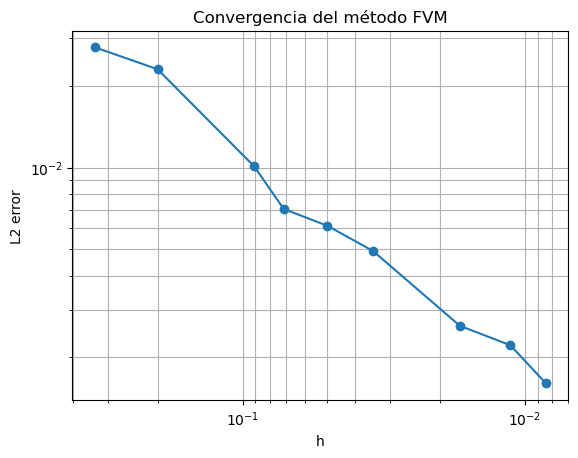

In [22]:
# --------------------------------------------------
# Gráfico de convergencia
# --------------------------------------------------
plt.figure()
plt.loglog(resolutions, errors_L2, 'o-')
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("Convergencia del método FVM")
plt.grid(True, which="both")
plt.gca().invert_xaxis()
plt.show()